In [ ]:
#|default_exp conv

# Convolutions

In [ ]:
#|export
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

from miniai.training import *
from miniai.datasets import *

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader
from typing import Mapping

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(linewidth=120)

In [ ]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In the context of an image, a feature is a visually distinctive attribute. For example, the number 7 is characterized by a horizontal edge near the top of the digit, and a top-right to bottom-left diagonal edge underneath that.

It turns out that finding the edges in an image is a very common task in computer vision, and is surprisingly straightforward. To do it, we use a *convolution*. A convolution requires nothing more than multiplication, and addition.

### Understanding the Convolution Equations

In [ ]:
x_train.shape

torch.Size([50000, 784])

In [ ]:
# resize to images sizes
x_imgs = x_train.view(-1,28,28)
xv_imgs = x_valid.view(-1,28,28)

In [ ]:
mpl.rcParams['figure.dpi'] = 70

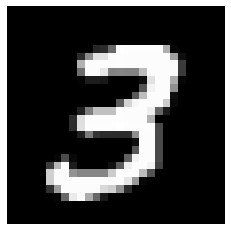

In [ ]:
im3 = x_imgs[7]
show_image(im3);

Create a top edge kernel detector

In [ ]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

We're going to call this our kernel (because that's what fancy computer vision researchers call these).

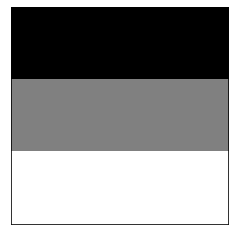

In [ ]:
show_image(top_edge, noframe=False);

The filter will take any window of size 3×3 in our images, and if we name the pixel values like this:

$$\begin{matrix} a1 & a2 & a3 \\ a4 & a5 & a6 \\ a7 & a8 & a9 \end{matrix}$$

it will return $-a1-a2-a3+a7+a8+a9$.

In [ ]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [ ]:
(im3[3:6,14:17] * top_edge).sum()

tensor(2.9727)

In [ ]:
(im3[7:10,14:17] * top_edge).sum()

tensor(-2.9570)

Create a function to calculate a 3x3 convolution over a given point on an `im3`

In [ ]:
def apply_kernel(row, col, kernel): return (im3[row-1:row+2,col-1:col+2] * kernel).sum()

In [ ]:
apply_kernel(4,15,top_edge)

tensor(2.9727)

In [ ]:
[[(i,j) for j in range(5)] for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

Note that we lose one point on each side of an image with a 3x3 kernel. Below we apply kernel to the whole image and plot it.

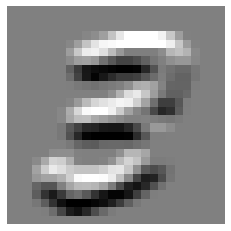

In [ ]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3);

Now let's construct a left edge kernel

In [ ]:
left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()

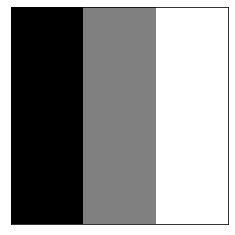

In [ ]:
show_image(left_edge, noframe=False);

And apply it to the image

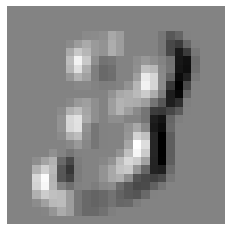

In [ ]:
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);

### Convolutions in PyTorch

In [ ]:
import torch.nn.functional as F
import torch

What to do if you have [2 months to complete your thesis](https://github.com/Yangqing/caffe/wiki/Convolution-in-Caffe:-a-memo)? Use [im2col](https://hal.inria.fr/inria-00112631/).

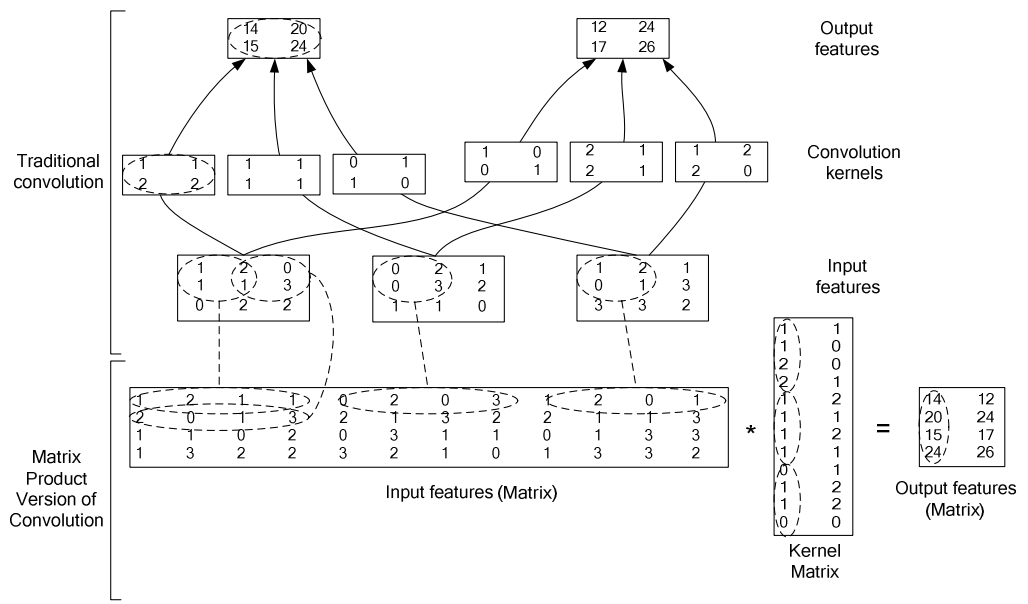

So what is F.unfold? It helps unfold an image to a given number of moving windos / patches. Let's look at examples below.

In [ ]:
o = torch.randn(7,7)[None,None]
o.shape, o

(torch.Size([1, 1, 7, 7]),
 tensor([[[[ 0.2403, -1.2415,  0.8532,  1.3843,  1.4524, -0.4636,  1.2007],
           [-2.1284,  1.0638, -1.2089, -0.6048,  0.2677,  0.1001, -1.6088],
           [ 0.3212,  0.7263,  0.4585, -1.1956, -0.9492, -1.5141,  0.7864],
           [-0.0854, -0.8396, -0.7565, -1.8619, -2.3807, -0.3358, -0.8042],
           [-0.1104,  1.9959,  0.9659, -0.0676, -0.9025, -0.9840,  0.9548],
           [-0.6850,  0.2869,  1.3585, -0.3340, -1.4912, -0.0164, -0.4540],
           [ 2.1586, -0.2184,  1.4501, -0.5591, -1.8817,  1.8304,  0.9959]]]]))

When applying a 3x3 kernel to a 7x7 image we get a total of 25 patches of size 3x3.

In simple terms, `torch.nn.Unfold` is a function in PyTorch that helps extract sliding or unfolding patches from input data. Imagine you have an image, and you want to extract small patches or windows from it. The `torch.nn.Unfold` function allows to define the size of these patches and the stride (the amount by which the patch slides over the image).

So the basic algorithm is as follows:
- It extracts sliding local blocks from a batched input tensor.
- It creates a new tensor where each patch from the input tensor is a column.
- It's often used in image processing and convolutional neural networks (CNNs).

Key Arguments:
- input: The input tensor to unfold.
- kernel_size: The size of the sliding kernel (window) to extract patches.
- stride: The stride between consecutive patches (default: 1).
- padding: The padding to apply to the input tensor (default: 0).
- dilation: The dilation factor for the kernel (default: 1).


In [ ]:
F.unfold(o, 3).shape, F.unfold(o, 3)

(torch.Size([1, 9, 25]),
 tensor([[[ 0.2403, -1.2415,  0.8532,  1.3843,  1.4524, -2.1284,  1.0638, -1.2089, -0.6048,  0.2677,  0.3212,  0.7263,
            0.4585, -1.1956, -0.9492, -0.0854, -0.8396, -0.7565, -1.8619, -2.3807, -0.1104,  1.9959,  0.9659, -0.0676,
           -0.9025],
          [-1.2415,  0.8532,  1.3843,  1.4524, -0.4636,  1.0638, -1.2089, -0.6048,  0.2677,  0.1001,  0.7263,  0.4585,
           -1.1956, -0.9492, -1.5141, -0.8396, -0.7565, -1.8619, -2.3807, -0.3358,  1.9959,  0.9659, -0.0676, -0.9025,
           -0.9840],
          [ 0.8532,  1.3843,  1.4524, -0.4636,  1.2007, -1.2089, -0.6048,  0.2677,  0.1001, -1.6088,  0.4585, -1.1956,
           -0.9492, -1.5141,  0.7864, -0.7565, -1.8619, -2.3807, -0.3358, -0.8042,  0.9659, -0.0676, -0.9025, -0.9840,
            0.9548],
          [-2.1284,  1.0638, -1.2089, -0.6048,  0.2677,  0.3212,  0.7263,  0.4585, -1.1956, -0.9492, -0.0854, -0.8396,
           -0.7565, -1.8619, -2.3807, -0.1104,  1.9959,  0.9659, -0.0676, -0.90

With a 6x6 kernel we get back only 4 possible patches

In [ ]:
o

tensor([[[[ 0.2403, -1.2415,  0.8532,  1.3843,  1.4524, -0.4636,  1.2007],
          [-2.1284,  1.0638, -1.2089, -0.6048,  0.2677,  0.1001, -1.6088],
          [ 0.3212,  0.7263,  0.4585, -1.1956, -0.9492, -1.5141,  0.7864],
          [-0.0854, -0.8396, -0.7565, -1.8619, -2.3807, -0.3358, -0.8042],
          [-0.1104,  1.9959,  0.9659, -0.0676, -0.9025, -0.9840,  0.9548],
          [-0.6850,  0.2869,  1.3585, -0.3340, -1.4912, -0.0164, -0.4540],
          [ 2.1586, -0.2184,  1.4501, -0.5591, -1.8817,  1.8304,  0.9959]]]])

In [ ]:
F.unfold(o, 6).shape, F.unfold(o, 6)

(torch.Size([1, 36, 4]),
 tensor([[[ 0.2403, -1.2415, -2.1284,  1.0638],
          [-1.2415,  0.8532,  1.0638, -1.2089],
          [ 0.8532,  1.3843, -1.2089, -0.6048],
          [ 1.3843,  1.4524, -0.6048,  0.2677],
          [ 1.4524, -0.4636,  0.2677,  0.1001],
          [-0.4636,  1.2007,  0.1001, -1.6088],
          [-2.1284,  1.0638,  0.3212,  0.7263],
          [ 1.0638, -1.2089,  0.7263,  0.4585],
          [-1.2089, -0.6048,  0.4585, -1.1956],
          [-0.6048,  0.2677, -1.1956, -0.9492],
          [ 0.2677,  0.1001, -0.9492, -1.5141],
          [ 0.1001, -1.6088, -1.5141,  0.7864],
          [ 0.3212,  0.7263, -0.0854, -0.8396],
          [ 0.7263,  0.4585, -0.8396, -0.7565],
          [ 0.4585, -1.1956, -0.7565, -1.8619],
          [-1.1956, -0.9492, -1.8619, -2.3807],
          [-0.9492, -1.5141, -2.3807, -0.3358],
          [-1.5141,  0.7864, -0.3358, -0.8042],
          [-0.0854, -0.8396, -0.1104,  1.9959],
          [-0.8396, -0.7565,  1.9959,  0.9659],
          [-0.7

In [ ]:
# Create a random 3-channel image of size 4x4
image = torch.rand(1, 3, 4, 4)

# Define the patch size and stride
patch_size = (2, 2)
stride = (1, 1)

# Create an Unfold module with the specified patch size and stride
patches = F.unfold(image, 2, stride=stride)

# Print the shape of the extracted patches
print(patches.shape)


torch.Size([1, 12, 9])


In [ ]:
image

tensor([[[[0.1021, 0.2962, 0.9329, 0.7009],
          [0.7476, 0.9009, 0.0408, 0.7781],
          [0.5265, 0.5523, 0.4611, 0.6840],
          [0.0597, 0.2053, 0.0901, 0.1516]],

         [[0.1728, 0.8150, 0.0949, 0.4585],
          [0.0792, 0.5092, 0.3054, 0.0578],
          [0.0097, 0.2351, 0.7862, 0.2600],
          [0.5136, 0.1487, 0.0863, 0.8252]],

         [[0.2235, 0.9253, 0.1919, 0.3894],
          [0.7228, 0.6189, 0.9842, 0.1700],
          [0.9494, 0.5109, 0.7990, 0.2884],
          [0.1249, 0.3723, 0.2176, 0.7963]]]])

In [ ]:
patches

tensor([[[0.1021, 0.2962, 0.9329, 0.7476, 0.9009, 0.0408, 0.5265, 0.5523, 0.4611],
         [0.2962, 0.9329, 0.7009, 0.9009, 0.0408, 0.7781, 0.5523, 0.4611, 0.6840],
         [0.7476, 0.9009, 0.0408, 0.5265, 0.5523, 0.4611, 0.0597, 0.2053, 0.0901],
         [0.9009, 0.0408, 0.7781, 0.5523, 0.4611, 0.6840, 0.2053, 0.0901, 0.1516],
         [0.1728, 0.8150, 0.0949, 0.0792, 0.5092, 0.3054, 0.0097, 0.2351, 0.7862],
         [0.8150, 0.0949, 0.4585, 0.5092, 0.3054, 0.0578, 0.2351, 0.7862, 0.2600],
         [0.0792, 0.5092, 0.3054, 0.0097, 0.2351, 0.7862, 0.5136, 0.1487, 0.0863],
         [0.5092, 0.3054, 0.0578, 0.2351, 0.7862, 0.2600, 0.1487, 0.0863, 0.8252],
         [0.2235, 0.9253, 0.1919, 0.7228, 0.6189, 0.9842, 0.9494, 0.5109, 0.7990],
         [0.9253, 0.1919, 0.3894, 0.6189, 0.9842, 0.1700, 0.5109, 0.7990, 0.2884],
         [0.7228, 0.6189, 0.9842, 0.9494, 0.5109, 0.7990, 0.1249, 0.3723, 0.2176],
         [0.6189, 0.9842, 0.1700, 0.5109, 0.7990, 0.2884, 0.3723, 0.2176, 0.7963]]])

The output is (1, 12, 9), indicating that we obtained 9 patches size 2x2x3 from the original image. The first dimension corresponds to the batch size, the second dimension represents the flattened patches (including the channel dimension - 2x2x3), and the last dimension indicates the number of extracted patches.

Each column shows a patch across dimensons. Now let's go to our original image (im3) and use F.unfold to calculate a convolution

In [ ]:
inp = im3[None,None,...].float()
inp_unf = F.unfold(inp, (3,3))[0]
inp_unf.shape

torch.Size([9, 676])

In [ ]:
w = left_edge.view(-1)
w.shape

torch.Size([9])

In [ ]:
out_unf = w@inp_unf
out_unf.shape

torch.Size([676])

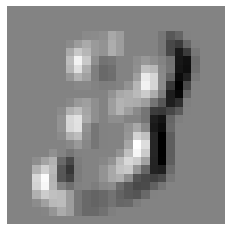

In [ ]:
out = out_unf.view(26,26)
show_image(out);

In [ ]:
%timeit -n 1 tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng]);

12 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit -n 100 (w@F.unfold(inp, (3,3))[0]).view(26,26);

The slowest run took 87.72 times longer than the fastest. This could mean that an intermediate result is being cached.
2.47 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit -n 100 F.conv2d(inp, left_edge[None,None])

The slowest run took 10.58 times longer than the fastest. This could mean that an intermediate result is being cached.
111 µs ± 97 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's also construct the diagonal edge detectors

In [ ]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

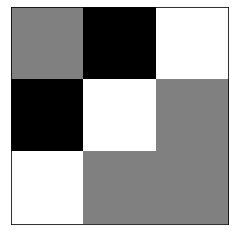

In [ ]:
show_image(diag1_edge, noframe=False);

In [ ]:
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

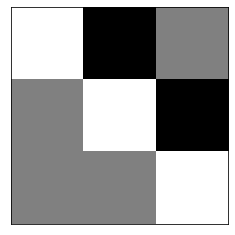

In [ ]:
show_image(diag2_edge, noframe=False);

In [ ]:
xb = x_imgs[:16][:,None]
xb.shape

torch.Size([16, 1, 28, 28])

Combine all of the above kernels in a single tensor

In [ ]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:,None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

And apply it to the xb

In [ ]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

The output shape shows we gave 64 images in the mini-batch, 4 kernels, and 26×26 edge maps (we started with 28×28 images, but lost one pixel from each side as discussed earlier). We can see we get the same results as when we did this manually:

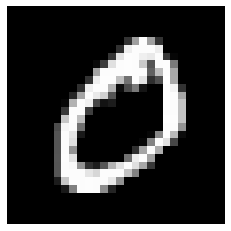

In [ ]:
img0 = xb[1,0]
show_image(img0);

Let's see how each of the edges looks like on a given input image

In [ ]:
?? show_images

Signature:
 show_images(
    ims: 'list',
    nrows: 'int | None' = None,
    ncols: 'int | None' = None,
    titles: 'list | None' = None,
    *,
    figsize: 'tuple' = None,
    imsize: 'int' = 3,
    suptitle: 'str' = None,
    sharex=False,
    sharey=False,
    squeeze=True,
    subplot_kw=None,
    gridspec_kw=None,
)
Docstring: <no docstring>
Source:   
@fc.delegates(subplots)
def show_images(ims: list, # Images to show
                nrows: int|None=None, # Number of rows in a grid
                ncols: int|None=None, # Number of columns in grid(auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs
               ):
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    # import ipdb; ipdb.set_trace()
    for im, t, ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)
File:      /notebooks/fastai-p2/miniai/datasets.py
Type:      function


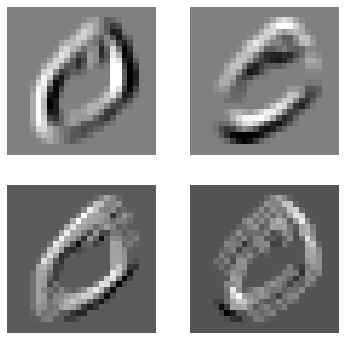

In [ ]:
show_images([batch_features[1,i] for i in range(4)])

### Strides and Padding

With appropriate padding, we can ensure that the output activation map is the same size as the original image.

If we add a kernel of size `ks` by `ks` (with `ks` an odd number), the necessary padding on each side to keep the same shape is `ks//2`.

We could move over two pixels after each kernel application. This is known as a *stride-2* convolution.

## Creating the CNN

In [ ]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

We cannot direcly replicate our approach with linear net: we will get back a 16x10x28x28 with a logit for each pixel in an image

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [ ]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,10, kernel_size=3, padding=1)
)

In [ ]:
broken_cnn(xb).shape, broken_cnn(xb).shape.numel()

(torch.Size([16, 10, 28, 28]), 125440)

Let's put the convolution layer in a function for ease of use.

In [ ]:
#|export
def conv(ni, nf, ks=3, stride=2, act=True):
    # conv layer with padding to keep the image size fixed (without accounting for stride)
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    # optionally add activation layer
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

Refactoring parts of your neural networks like this makes it much less likely you'll get errors due to inconsistencies in your architectures, and makes it more obvious to the reader which parts of your layers are actually changing.

In [ ]:
(7-3+2)//2 + 1

4

In [ ]:
simple_cnn = nn.Sequential(
    # 4-8-16-16-10
    conv(1 ,4),            #14x14 / (28-3+2)//2 + 1
    conv(4 ,8),            #7x7 / (14-3+2)//2 + 1
    conv(8 ,16),           #4x4 / (7-3+2)//2 + 1
    conv(16,16),           #2x2
    conv(16,10, act=False), #1x1
    nn.Flatten(), # convert two reduntant trailing 1x1 
)

In [ ]:
simple_cnn(xb).shape

torch.Size([16, 10])

In [ ]:
x_imgs = x_train.view(-1,1,28,28)
xv_imgs = x_valid.view(-1,1,28,28)
train_ds,valid_ds = Dataset(x_imgs, y_train),Dataset(xv_imgs, y_valid)

Add functions to put all of our data on a target device ('mps' if such backend if avaiable 'cuda' or 'cpu')

In [ ]:
#|export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    # if tensor -> move it to device
    if isinstance(x, torch.Tensor): return x.to(device)
    # if Mapping -> move each value to a device
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    # if not tensor or Mapping -> move each of its element to a device and cast to a relevant type
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

In [ ]:
# EXAMPLE for `to_device`
t = [torch.tensor(1), torch.tensor(2)]
to_device(t)

[tensor(1, device='cuda:0'), tensor(2, device='cuda:0')]

Reminder how collate_device works

In [ ]:
t = [{'a':1, 'b': 2}, {'a': 5, 'b': 6}]
collate_device(t)

{'a': tensor([1, 5], device='cuda:0'), 'b': tensor([2, 6], device='cuda:0')}

In [ ]:
??get_dls

Signature: get_dls(train_ds, valid_ds, bs, **kwargs)
Docstring: <no docstring>
Source:   
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, bs, shuffle=True, **kwargs), DataLoader(valid_ds, bs*2, **kwargs))
File:      /notebooks/fastai-p2/miniai/training.py
Type:      function


In [ ]:
from torch import optim

bs = 256
lr = 0.4
# get train and valid dataloaders using our miniai function
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [ ]:
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 2.2977261913299563 0.10639999992847443
1 0.3936723113059998 0.8769999994277954
2 0.2546222189426422 0.9178999997138977
3 0.25748306317329406 0.9189000000953674
4 0.20625101625919343 0.9373000001907349


Reduce the learning rate by a factor of 4 and train for another 5 epochs.

In [ ]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.0942796897649765 0.9722999993324279
1 0.0972685335636139 0.9722000008583069
2 0.09327651886940003 0.9736000008583069
3 0.09744440944194793 0.9715000008583069
4 0.0859081603527069 0.9761999994277955


### Understanding Convolution Arithmetic

In an input of size `64x1x28x28` the axes are `batch,channel,height,width`. This is often represented as `NCHW` (where `N` refers to batch size). Tensorflow, on the other hand, uses `NHWC` axis order (aka "channels-last"). Channels-last is faster for many models, so recently it's become more common to see this as an option in PyTorch too.

We have 1 input channel, 4 output channels, and a 3×3 kernel.

In [ ]:
simple_cnn[0][0]

Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [ ]:
conv1 = simple_cnn[0][0]
conv1.weight.shape

torch.Size([4, 1, 3, 3])

In [ ]:
conv1.bias.shape

torch.Size([4])

## Color Images

A colour picture is a rank-3 tensor:

In [ ]:
from torchvision.io import read_image

In [ ]:
im = read_image('images/grizzly.jpg')
im.shape

torch.Size([3, 612, 408])

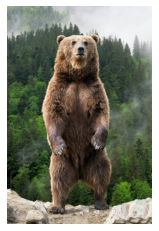

In [ ]:
show_image(im.permute(1,2,0));

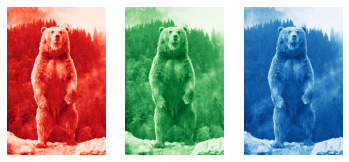

In [ ]:
_,axs = plt.subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')): show_image(255-bear, ax=ax, cmap=color)

These are then all added together, to produce a single number, for each grid location, for each output feature.

We have `ch_out` filters like this, so in the end, the result of our convolutional layer will be a batch of images with `ch_out` channels.

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()